In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('../../', 'chatbot')))

In [2]:
from dotenv import load_dotenv, find_dotenv
from langchain_community.graphs import Neo4jGraph

load_dotenv(find_dotenv())
db = Neo4jGraph()

In [3]:
from langchain_openai import ChatOpenAI
from graph import calculate_risk_coefficients, car_analysis, go_to_searcher
from guardian import Guardian,  PictureAnalyzer
from query_generator import create_query_generator
from langgraph.prebuilt import ToolNode

llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0
)
picture_analysis = PictureAnalyzer(llm).create_picture_analyzer()
query_gen = create_query_generator(llm, db)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL (row) { ... }} {position: line: 1, column: 21, offset: 20} for query: "UNWIND $data AS row CALL { WITH row MERGE (c:`Chunk` {id: row.id}) WITH c, row CALL db.create.setNodeVectorProperty(c, 'embedding', row.embedding) SET c.`text` = row.text SET c += row.metadata } IN TRANSACTIONS OF 1000 ROWS "


In [4]:
guardian = Guardian(llm, [go_to_searcher])
llm_with_guardian = guardian.create_guardian()
search_node = ToolNode([go_to_searcher])

In [5]:
tool_node = ToolNode([calculate_risk_coefficients, car_analysis])

In [6]:
from caller import Caller

mini_llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

caller = Caller(mini_llm, [calculate_risk_coefficients, car_analysis]).create_caller()

app_tools = {
    'db': db,
    'caller': caller,
    'guardian': llm_with_guardian,
    'cypher': query_gen,
    'picture': picture_analysis,
}

In [7]:
from graph import State, compile_graph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph

graph = StateGraph(State)
memory = MemorySaver()

app = compile_graph(graph, memory, search_node, tool_node)

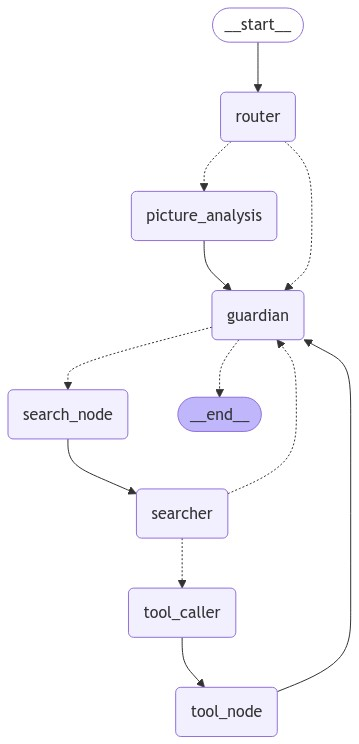

In [8]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

config = {"configurable": {"thread_id": "1"}, "recursion_limit": 15}
config['configurable'].update(app_tools)

In [9]:
user_input = "Dimmi di Vito Teci"

events = app.astream(
    {"messages": ("user", user_input), "is_picture": False}, config=config, stream_mode="values",
)
async for event in events:
    event["messages"][-1].pretty_print()
    final_message = event

================================ Human Message =================================

Dimmi di Vito Teci
================================ Human Message =================================

Dimmi di Vito Teci
================================== Ai Message ==================================
Tool Calls:
  go_to_searcher (call_ONgB8cIav4zWyCVv9hAxAQeL)
 Call ID: call_ONgB8cIav4zWyCVv9hAxAQeL
  Args:
    state: {'messages': [{'content': 'Dimmi di Vito Teci', 'type': 'human'}], 'data': None, 'is_picture': None}
================================= Tool Message =================================
Name: go_to_searcher

search
Searcher query: MATCH (p:Person {name: 'Vito', last_name: 'Teci'}) RETURN p
================================== Ai Message ==================================

[{'p': {'cf': 'TCEVTI58M05B354M', 'birthdate': '1958-08-05', 'gender': 'M', 'birthplace': 'CAGLIARI', 'name': 'Vito', 'last_name': 'Teci', 'residence': 'ORISTANO'}}]
================================== Ai Message ================

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n    MATCH (p:Person {cf: 'TCEVTI58M05B354M'})\n    OPTIONAL MATCH (p)-[:HAS_COMMITTED]->(c:Crime)\n    OPTIONAL MATCH (p)-[:PARTNER_OF]->(p1:Person)-[:HAS_COMMITTED]->(c1:Crime)\n    OPTIONAL MATCH (p)-[:CHILD_OF]->(p2:Person)-[:HAS_COMMITTED]->(c2:Crime)\n    OPTIONAL MATCH (p)<-[:CHILD_OF]-(p3:Person)-[:HAS_COMMITTED]->(c3:Crime)\n    OPTIONAL MATCH (p)-[:WORK_AT]->(w:Workplace)<-[:WORK_AT]-(p4:Person)-[:HAS_COMMITTED]->(c4:Crime)\n    RETURN \n        COALESCE(SUM(DISTINCT c.severity_score), 0) AS direct_crime_score, \n        COALESCE(SUM(DISTINCT c1.severity_score), 0) AS partner_crime_score,\n        COALESCE(SUM(DISTINCT c2.severity_score), 0) AS parents_crime_score, \n     

================================= Tool Message =================================
Name: calculate_risk_coefficients

{"direct_crime_score": 0, "partner_crime_score": 0, "parents_crime_score": 0, "children_crime_score": 0, "colleagues_crime_score": 0, "weighted_risk_score": 0.0}
================================== Ai Message ==================================

**Informazioni su Vito Teci**

| Campo         | Dettaglio         |
|---------------|-------------------|
| Codice Fiscale| TCEVTI58M05B354M  |
| Data di Nascita| 1958-08-05        |
| Genere        | M                 |
| Luogo di Nascita| CAGLIARI         |
| Nome          | Vito              |
| Cognome       | Teci              |
| Residenza     | ORISTANO          |

**Report:**
Vito Teci è nato il 5 agosto 1958 a Cagliari e attualmente risiede a Oristano. Non ci sono ulteriori dettagli disponibili nel database.

**Coefficiente di Rischio di Vito Teci**

| Tipo di Rischio          | Punteggio |
|--------------------------|----

In [10]:
image_url = "https://immagini.alvolante.it/sites/default/files/styles/anteprima_640/public/dasapere_galleria/2024/07/targa-italiana-987.jpg"
import httpx
import base64
image_data = base64.b64encode(httpx.get(image_url).content).decode("utf-8")
image = f"{image_data}"

In [11]:
events = app.astream(
    {"messages": ("user", image), "is_picture": True}, config=config, stream_mode="values",
)
async for event in events:
    event["messages"][-1].pretty_print()
    final_message = event

================================ Human Message =================================

/9j/4AAQSkZJRgABAQEBLAEsAAD/2wBDAAUDBAQEAwUEBAQFBQUGBwwIBwcHBw8LCwkMEQ8SEhEPERETFhwXExQaFRERGCEYGh0dHx8fExciJCIeJBweHx7/2wBDAQUFBQcGBw4ICA4eFBEUHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh7/wAARCAGrAoADASEAAhEBAxEB/8QAHQAAAgMBAQEBAQAAAAAAAAAAAQIAAwQFBgcICf/EAFkQAAEDAgMEBgUHBwgHBgYCAwEAAgMEEQUSIQYxQVEHE2FxgZEUIjJSoQgVQmKxwdEjM0NTcoKSFlRzk6KywuEkNERjg9LwNUVVZISjJTZ0lOLxFyZ1hbP/xAAbAQADAAMBAQAAAAAAAAAAAAAAAQIDBAUGB//EADwRAAIBAwIDBgIIBQQDAQEAAAABAgMREgQhMUFRBRMiYXGxBjIUQnKBkaHB8CMkM9HhNDVS8SVDYhXC/9oADAMBAAIRAxEAPwDx71USvEI+n2DTw9bJY+C5e1ANJAXgi44IpTvWUDia7WRhN0zy1NXVL3OAkcAeCrzzOlH5M37F2mopWR5qhTwk6jHa+KKI59XE6krkmsgfiJc3VjAXvI90b/w8U9PTlKTsb2oq03TSF2wqZKWgpsGcbVErhXYh/SOH5OM/sMN7c3nkvKuPAak6d677SWy5HAvfdnqdnKQQQ9Y63qak9vNfbOjzCPmnZz0uZmWrr7SvuNWx/Qb5HMf2uxcTt+thpVBfWfsd74eo56lz/wCK9zlbYYtDFjFLFKA+GiYcRnYdzyw5YWH9qQg9zSvieJYhNiGN1mLVUnWygmTMfpPOjfxVdh08KEW+e5Pb1XPVSS5WR32H/Roxe/qD7FnkOq

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n    MATCH (p:Person {cf: 'MLLBDT50P08E335S'})\n    OPTIONAL MATCH (p)-[:HAS_COMMITTED]->(c:Crime)\n    OPTIONAL MATCH (p)-[:PARTNER_OF]->(p1:Person)-[:HAS_COMMITTED]->(c1:Crime)\n    OPTIONAL MATCH (p)-[:CHILD_OF]->(p2:Person)-[:HAS_COMMITTED]->(c2:Crime)\n    OPTIONAL MATCH (p)<-[:CHILD_OF]-(p3:Person)-[:HAS_COMMITTED]->(c3:Crime)\n    OPTIONAL MATCH (p)-[:WORK_AT]->(w:Workplace)<-[:WORK_AT]-(p4:Person)-[:HAS_COMMITTED]->(c4:Crime)\n    RETURN \n        COALESCE(SUM(DISTINCT c.severity_score), 0) AS direct_crime_score, \n        COALESCE(SUM(DISTINCT c1.severity_score), 0) AS partner_crime_score,\n        COALESCE(SUM(DISTINCT c2.severity_score), 0) AS parents_crime_score, \n     

================================= Tool Message =================================
Name: car_analysis

{"revision_status": "ok", "insurance_status": "ok", "is_stolen": false}
================================== Ai Message ==================================

**Informazioni su Benedetto Milello**

| Campo         | Dettaglio         |
|---------------|-------------------|
| Codice Fiscale| MLLBDT50P08E335S  |
| Data di Nascita| 1950-09-08        |
| Genere        | M                 |
| Luogo di Nascita| ISERNIA          |
| Nome          | Benedetto         |
| Cognome       | Milello           |
| Residenza     | CAMPOBASSO        |

**Report:**
Benedetto Milello è nato l'8 settembre 1950 a Isernia e attualmente risiede a Campobasso. Non ci sono ulteriori dettagli disponibili nel database.

**Coefficiente di Rischio di Benedetto Milello**

| Tipo di Rischio          | Punteggio |
|--------------------------|-----------|
| Rischio Diretto          | 0         |
| Rischio da Partner       |

In [12]:
print(final_message["messages"][-1].content)

**Informazioni su Benedetto Milello**

| Campo         | Dettaglio         |
|---------------|-------------------|
| Codice Fiscale| MLLBDT50P08E335S  |
| Data di Nascita| 1950-09-08        |
| Genere        | M                 |
| Luogo di Nascita| ISERNIA          |
| Nome          | Benedetto         |
| Cognome       | Milello           |
| Residenza     | CAMPOBASSO        |

**Report:**
Benedetto Milello è nato l'8 settembre 1950 a Isernia e attualmente risiede a Campobasso. Non ci sono ulteriori dettagli disponibili nel database.

**Coefficiente di Rischio di Benedetto Milello**

| Tipo di Rischio          | Punteggio |
|--------------------------|-----------|
| Rischio Diretto          | 0         |
| Rischio da Partner       | 0         |
| Rischio da Genitori      | 0         |
| Rischio da Figli         | 0         |
| Rischio da Colleghi      | 0         |
| Punteggio di Rischio Ponderato | 0.0       |

**Report:**
Il coefficiente di rischio per Benedetto Milello è pari a 0

In [13]:
snapshot = app.get_state(config).values
from pprint import pprint
pprint(snapshot)

{'data': [{'p': {'birthdate': '1958-08-05',
                 'birthplace': 'CAGLIARI',
                 'cf': 'TCEVTI58M05B354M',
                 'gender': 'M',
                 'last_name': 'Teci',
                 'name': 'Vito',
                 'residence': 'ORISTANO'}},
          {'p': {'birthdate': '1950-09-08',
                 'birthplace': 'ISERNIA',
                 'cf': 'MLLBDT50P08E335S',
                 'gender': 'M',
                 'last_name': 'Milello',
                 'name': 'Benedetto',
                 'residence': 'CAMPOBASSO'}}],
 'is_picture': True,
 'messages': [HumanMessage(content='Dimmi di Vito Teci', additional_kwargs={}, response_metadata={}, id='eb01710d-c181-4998-af33-ef5607431091'),
              AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ONgB8cIav4zWyCVv9hAxAQeL', 'function': {'arguments': '{"state":{"messages":[{"content":"Dimmi di Vito Teci","type":"human"}],"data":null,"is_picture":null}}', 'name': 'go_to_searcher'}, '